# Estimación del contenido de glucógeno en un corte histológico con tinción PAS

## Miguel Rojas

## 30/IX/2025

En el siguiente notebook, se pretende hacer una estimación del porcentaje de glucógeno por superficie que se encuentra en el hígado (más específicamente, en los hepatocitos) en estado pospandrial (después de comer). Normalmente, la cantidad de glucógeno en el hígado se cuantifica de las siguientes formas:

1. Masa por célula (Bezborodkina y col., 2022).
2. Masa por gramo de hígado (Fernández-Novell y col., 1992; Fernández-Novell y col., 2002).
3. Masa por unidad de proteína (O'Doherty y col., 2000).

En este sentido, medir glucógeno hepático como porcentaje de superficie en láminas histológicas puede ser una aproximación práctica y rápida, ya que utiliza tinciones de rutina, requiere poco tejido y permite evaluar distribución espacial y heterogeneidad entre hepatocitos.

En muestras histológicas, el glucógeno puede detectarse utilizando la reacción PAS o Ácido Peryódico de Schiff (del inglés *Periodic Acid-Schiff*), el cual tiñe los carbohidratos de color magenta. Esta reacción se basa en la ruptura de los enlaces entre carbonos adyacentes con grupos hidroxilo, que luego se oxidan y convierten en grupos aldehído. Estos grupos aldehído reaccionan con el reactivo de Schiff, formando un compuesto de color magenta (Pawlina, 2024). El reactivo de Schiff se prepara tratando colorante de fucsina con gas de dióxido de azufre ($SO_{2}$) o con bisulfito de sodio ($NaHSO_{3}$). La intensidad del color es directamente proporcional a la concentración de grupos aldehído reactivos (Sorenson y Brelje, 2015).

El hígado en estado pospandrial (*fed*) almacena el glucógeno de dos maneras: 1) como partículas $\beta$ pequeñas y 2) como partículas $\alpha$ o agregados compuestos de partículas $\beta$ (Tan y col., 2018). Estas se hallan en mayor proporción en el citosol, y aproximadamente un 10% del glucógeno en los hepatocitos está en los lisosomas (Roach, 2002). Así, el glucógeno puede localizarse como una estructura granular gruesa y fuertemente teñida de color magenta intenso en casi todos los hepatocitos (Sorenson y Brelje, 2015).

Primero, se cargan las librerías respectivas.

In [ ]:
# install.packages('magick')
# install.packages('colorfindr')
# install.packages('tidyverse')
# install.packages('DT')

library(magick)
library(colorfindr)
library(tidyverse)
library(DT)

Ahora, se carga la imagen al entorno. Dicha imagen corresponde a una vista detallada de los hepatocitos de una sección de hígado, la cual puede encontrarse en [Histology Guide (Sorenson y Brelje, 2015)](https://www.histologyguide.com/slideview/MH-128-liver/15-slide-1.html?x=19227&y=43407&z=100.00&f=1). La misma se guarda como `Histology-Guide-001.jpg`. Esta se edita antes de utilizarla para ajustarla a las dimensiones de 1300 px de ancho por 700 px de largo.

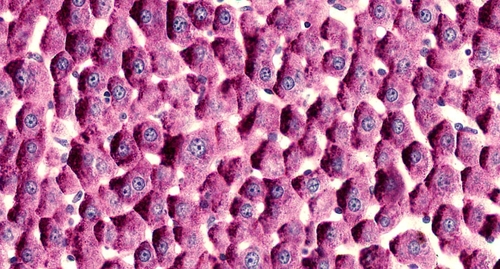

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 JPEG     500    269 sRGB       FALSE        0 72x72  

In [3]:
path <- 'Histology-Guide-001.jpg'
liver <- image_read(path = path)
liver %>% image_resize('500x')

De la imagen anterior, se extrae la siguiente información:

In [4]:
info <- image_info(liver)
info

format,width,height,colorspace,matte,filesize,density
<chr>,<int>,<int>,<chr>,<lgl>,<int>,<chr>
JPEG,1300,700,sRGB,FALSE,691841,72x72


Se crea la función `get_tile()`, la cual se utiliza para separar la imagen en teselas o fragmentos de 100x100 px.

In [5]:
get_tile <- function(image, row, col, tile = 100) {
  # geometry: widthxheight+x+y  (el desplazamiento comienza en 0)
  x <- col * tile
  y <- row * tile
  geo <- sprintf("%dx%d+%d+%d", tile, tile, x, y)
  image_crop(image, geometry = geo, gravity = "NorthWest")
}

Se crea el directorio `/tiles` en caso de que no exista. Aquí se almacenan las imágenes de las teselas.

In [6]:
out_dir <- "tiles"
if (!dir.exists(out_dir)) dir.create(out_dir)

Luego, se hace un ciclo `for` anidado dentro de otro ciclo `for`, donde el primero corresponde a las filas (`r`) y el segundo a las columnas (`c`).

In [ ]:
for (r in 0:6) {
  for (c in 0:12) {
    tile_img <- get_tile(liver, r, c)
    filename <- file.path(out_dir, sprintf("tile_r%02d_c%02d.png", r, c))
    image_write(tile_img, path = filename, format = "png")
  }
}

Los tres bloques de código anteriores fueron generados usando GPT-5 mini (Duck.ai Assistant, 2025), usando el siguiente prompt:

> - I have a 700x700 px image that I want to crop into 100 images of size 70x70 starting from a grid. I want to do this in R, using the `magick` package. Show me the code to do that and explain it step by step.

Posteriormente, se modificó el código (mostrado arriba) para adaptarlo a las dimensiones de 1300x700.

Ahora, se extraen las rutas de los archivos de las teselas.

In [7]:
tile_paths <- paste0(getwd(), '/', out_dir, '/', list.files(out_dir))

Se cargan todas las teselas como imagen y se guardan en una lista:

In [8]:
n <- length(tile_paths)
img.list <- vector('list', n) # Crear lista de elementos vacíos
names(img.list) <- paste0('img.', 1:n) # Cambiar de nombre a los elementos

for(i in 1:n){
  img.list[[i]] <- image_read(tile_paths[i])
}

Para representar la imagen del corte histológico de la manera más sencilla posible, se crea una paleta de colores tal como esta.

In [15]:
png(filename = 'palette2.png', width = 2000, height = 1500)
set.seed(123)
palette <- get_colors(img = tile_paths[5]) %>% make_palette(n = 5)
dev.off()

agg_record_1533115835 
                    2

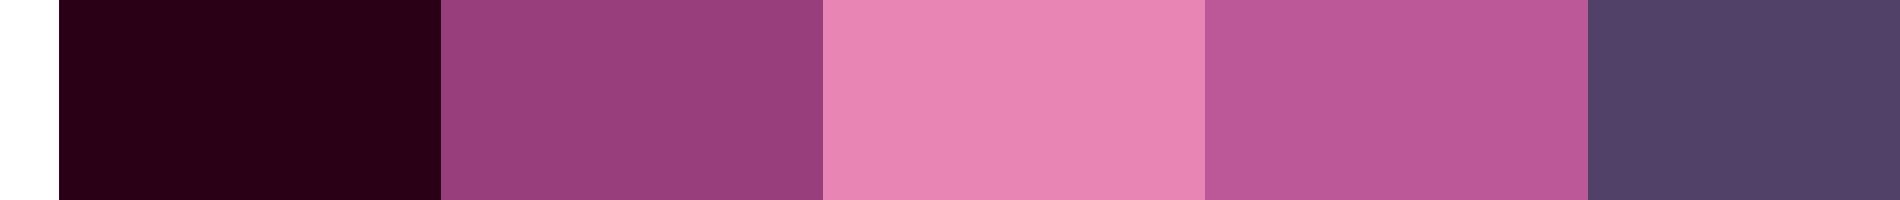

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1900    200 sRGB       FALSE        0 72x72  

In [9]:
img_palette <- image_read(path = 'palette2.png') %>% image_crop(geometry = '1900x200+0+400')
img_palette

De esta paleta de colores, en realidad no se tienen `n = 5` colores, ya que el color blanco del fondo también cuenta, por lo que serían `n = 6`. Ahora, se mapean cada una de las teselas partiendo de la paleta de colores anterior. Se aprovecha el color blanco del borde para mapear los espacios entre las células.

In [10]:
img_map <- vector('list', n)
names(img_map) <- paste0('img.', 1:n)

for(i in 1:n){
  img_map[[i]] <- image_map(img.list[[i]], map = img_palette, dither = F)
}

Se puede observan cómo quedan las teselas luego de mapear los colores usando las funciones `image_join()` e `image_montage()`.

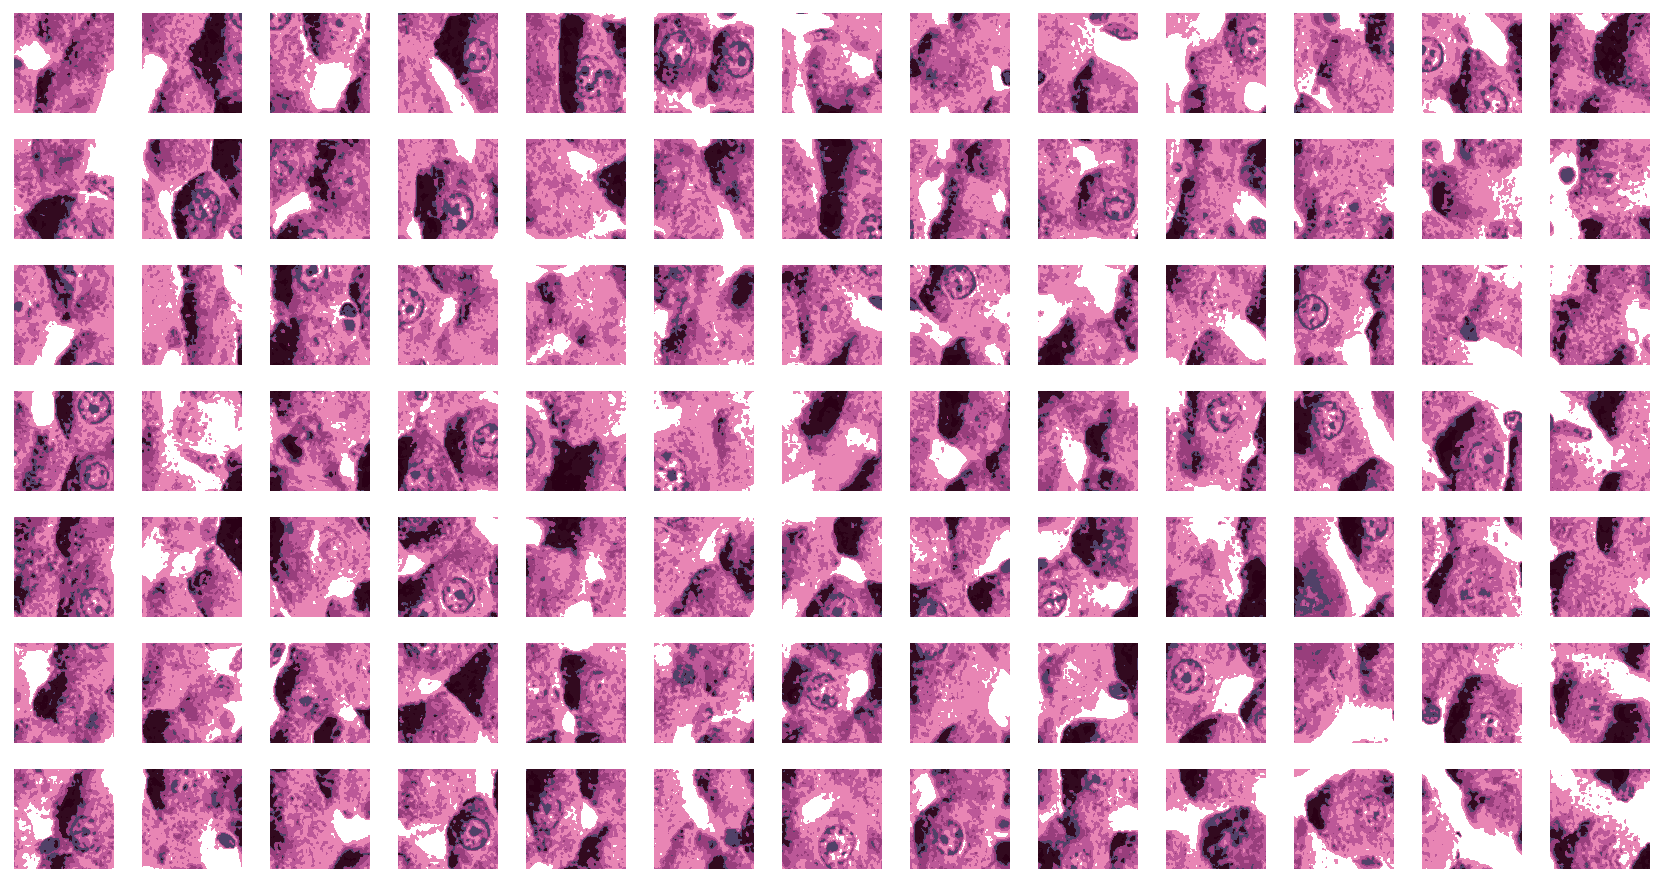

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 ""      1664    882 sRGB       FALSE        0 72x72  

In [11]:
image_montage(image_join(img_map), tile = '13x7')

Las zonas más oscuras, con tonalidades entre vinotinto y violeta, corresponden a los agregados de partículas $\beta$ y $\alpha$ con contenido de glucógeno.

El siguiente paso es contar la cantidad de veces que aparecen estos colores de la paleta en la imagen. Para ello, se utiliza la función `count_colors()`, la cual es tomada y adaptada de la presentación [Working with Images in R](https://jeroen.github.io/munster2018/) de Ooms (2016).

In [12]:
count_colors <- function(image) {
  data <- image_data(image) %>%
    apply(2:3, paste, collapse = "") %>% 
    as.vector %>% table() %>%  as.data.frame() %>% 
    setNames(c("hex", "freq"))
  
  dims <- as.numeric(image_info(image)[c('width','height')])
  dim <- dims[1]*dims[2]
  
  data$hex <- paste("#", data$hex, sep="")
  data$freq <- data$freq/dim
  return(data)
}

Se crea una lista llamada `frequency` para almacenar la frecuencia de aparición de cada color en cada una de las teselas, lo que crea 91 data frames. Asimismo, se crea la variable `tile_id`. Esto último se realiza principalmente por dos razones:

1. identificar a qué tesela pertenece cada observación, y

2. posible aparición de otros colores debido a la posterización de las imágenes durante el mapeo. Luego, al combinar todos los data frames en un solo data frame, esto permite agrupar por tesela los colores que probablemente son indicativos de la presencia de glucógeno.

In [13]:
# Lista para almacenar los data frames de frecuencia de aparición de cada color
frequency <- list()

# Ciclo for 
for(i in 1:n){
  temp <- count_colors(img_map[[i]])
  temp$tile_id <- rep(paste0('img.',i), nrow(temp))
  frequency[[i]] <- temp
}

Se combinan todos los data frames almacenados en `frequency` en un único data frame.

In [14]:
frequency <- do.call(rbind, frequency)

Se visualiza la tabla de frecuencias.

In [15]:
DT::datatable(frequency) %>%
formatStyle('hex', backgroundColor = styleEqual(frequency$hex, frequency$hex), color = 'blue')

HTML widgets cannot be represented in plain text (need html)

Se determina cuáles son los colores que aparecen en el data frame.

In [33]:
unique(frequency$hex)

[1] "#2a0016" "#320a1f" "#514168" "#983e7c" "#bc5898" "#e885b4" "#ffffff"

De la tabla anterior, se toman solo los colores #2a0016, #320a1f y #983e7c y se extrae el vector `gly.freq.sample` que contiene la frecuencia de glucógeno estimada para cada tesela.

In [34]:
gly.freq.sample <- frequency %>%
  filter(hex == '#2a0016' | hex == '#320a1f' | hex == '#983e7c') %>%
  group_by(tile_id) %>%
  summarise(freq = sum(freq)) %>%
  deframe()

gly.freq.sample

img.1 img.10 img.11 img.12 img.13 img.14 img.15 img.16 img.17 img.18 img.19 
0.3242 0.1445 0.1749 0.2006 0.4257 0.2736 0.3497 0.3392 0.2508 0.1466 0.2694 
 img.2 img.20 img.21 img.22 img.23 img.24 img.25 img.26 img.27 img.28 img.29 
0.3872 0.3242 0.2372 0.1792 0.2528 0.1699 0.1845 0.1704 0.1720 0.1810 0.3278 
 img.3 img.30 img.31 img.32 img.33 img.34 img.35 img.36 img.37 img.38 img.39 
0.2172 0.1599 0.1252 0.2682 0.1979 0.1653 0.2287 0.1939 0.2119 0.0971 0.2718 
 img.4 img.40 img.41 img.42 img.43 img.44 img.45 img.46 img.47 img.48 img.49 
0.2673 0.2732 0.1065 0.2717 0.3123 0.3004 0.0733 0.2623 0.3407 0.2862 0.2217 
 img.5 img.50 img.51 img.52 img.53 img.54 img.55 img.56 img.57 img.58 img.59 
0.3573 0.2943 0.3042 0.1612 0.4087 0.2293 0.2328 0.3099 0.2090 0.2392 0.2965 
 img.6 img.60 img.61 img.62 img.63 img.64 img.65 img.66 img.67 img.68 img.69 
0.2763 0.2121 0.2476 0.2340 0.2922 0.1846 0.2000 0.2650 0.2083 0.2610 0.4053 
 img.7 img.70 img.71 img.72 img.73 img.74 img.75 img.76 img.77 img.78 img.79 
0.1464 0.2349 0.1499 0.3366 0.1326 0.2205 0.2282 0.1907 0.2226 0.2955 0.2329 
 img.8 img.80 img.81 img.82 img.83 img.84 img.85 img.86 img.87 img.88 img.89 
0.1597 0.2353 0.2376 0.1893 0.3163 0.2190 0.1404 0.2322 0.2955 0.2793 0.1742 
 img.9 img.90 img.91 
0.1191 0.1208 0.2217

Se puede aproximar la distribución del promedio de la frecuencia realizando un remuestreo por *bootstrap*.

In [35]:
B <- 9999
freq.means <- vector('numeric', B)

set.seed(123)
for(i in 1:B){
  sample.f <- sample(gly.freq.sample, size = length(gly.freq.sample), replace = T)
  freq.means[i] <- mean(sample.f)
}

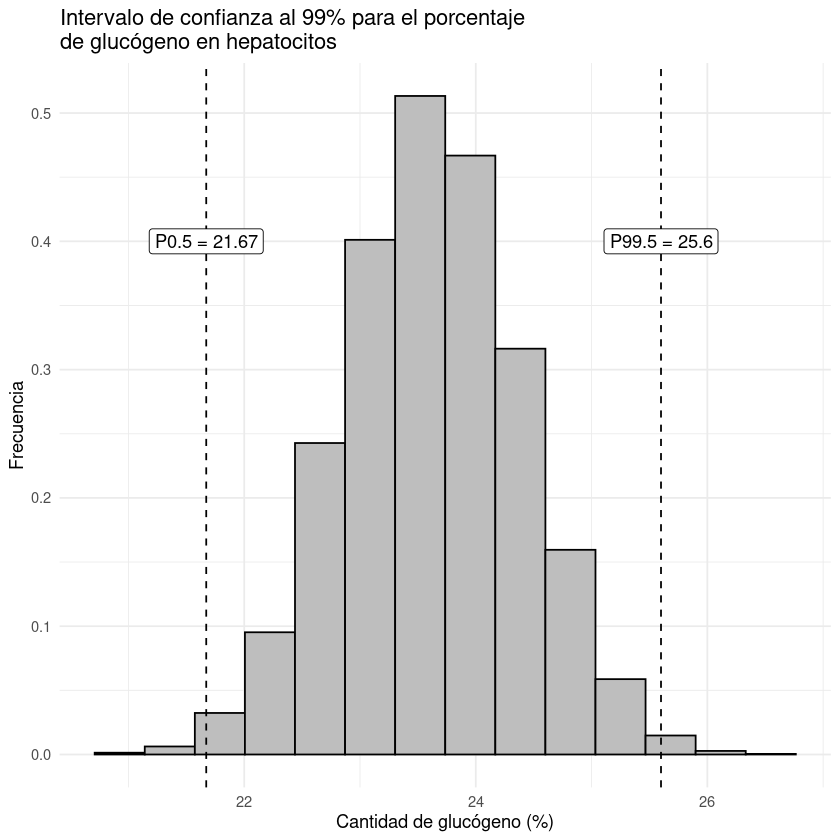

In [36]:
freq.means %>%
  as_tibble() %>%
  ggplot(aes(x = value*100)) +
  geom_histogram(aes(y = after_stat(density)), bins = 14, fill = 'gray', color = 'black') +
  geom_vline(xintercept = 100*quantile(freq.means, probs = c(0.005, 0.995)), linetype = 'dashed') +
  labs(
    x = 'Cantidad de glucógeno (%)',
    y = 'Frecuencia',
    title = 'Intervalo de confianza al 99% para el porcentaje\nde glucógeno en hepatocitos'
  ) +
  annotate(geom = 'label', x = 100*quantile(freq.means, probs = c(0.005)), y = 0.4, label = paste0('P0.5 = ', 100*round(quantile(freq.means, probs = c(0.005)), 4))) +
  annotate(geom = 'label', x = 100*quantile(freq.means, probs = c(0.995)), y = 0.4, label = paste0('P99.5 = ', 100*round(quantile(freq.means, probs = c(0.995)), 4))) +
  theme_minimal()

## Limitaciones

Expresar el área teñida por PAS normaliza parcialmente las variaciones en tamaño de sección y facilita comparaciones iniciales. Sin embargo, esto no refleja la masa absoluta ni la concentración por célula, la cual depende del grosor de la sección, la fijación e intensidad de tinción, y por lo tanto necesita ser estandarizado. Por ello, debe complementarse con cuantificaciones bioquímicas para medidas precisas.

## Referencias

- Bezborodkina, N. N., Stepanov, A. V., Vorobev, M. L., Stein, G. I., Okovityi, S. V. y Kudryavtsev, B. N. (2022). Dynamics of the Glycogen β-Particle Number in Rat Hepatocytes during Glucose Refeeding. *Int. J. Mol. Sci.*, **23(16)**: 9263. https://doi.org/10.3390/ijms23169263.

- Duck.ai Assistant. (2025). Code and explanation for cropping a 700×700 image into 100 70×70 tiles using magick in R [respuesta generada por IA]. Duck.ai. https://duck.ai/. [Consulta: 30 de septiembre de 2025].

- Fernández-Novell, J. M., Ariño, J., Vilaró, S. y Guinovart, J. J. (1992). Glucose induces the translocation and the aggregation of glycogen synthase in rat hepatocytes. *Biochem. J.*, **281(2)**: 443–448. https://doi.org/10.1042/bj2810443

- Fernández-Novell, J. M., López-Iglesias, C., Ferrer, J. C. y Guinovart, J. J. (2002). Zonal distribution of glycogen synthesis in isolated rat hepatocytes. *FEBS Lett.*, **531(2)**: 222–228. https://doi.org/10.1016/s0014-5793(02)03506-8.

- O’Doherty, R. M., Jensen, P. B., Anderson, P., Jones, J. G., Berman, H. K., Kearney, D. y Newgard, C. B. (2000). Activation of direct and indirect pathways of glycogen synthesis by hepatic overexpression of protein targeting to glycogen. *J. Clin. Invest.*, **105(4)**: 479–488. https://doi.org/10.1172/jci8673

- Ooms, J. (2016). Working with Images in R (Presentación). Institute for Geoinformatics, WWU Münster. https://jeroen.github.io/munster2018/. [Consulta: 30 de septiembre de 2025].

- Pawlina, W. (2024). Histology: A Text and Atlas. Wolters Kluwer. Novena Edición. Filadelfia, EUA.

- Roach, P. (2002). Glycogen and its Metabolism. *Curr. Mol. Med.*, **2(2)**: 101–120. https://doi.org/10.2174/1566524024605761

- Sorenson, R. L. y Brelje, C. B. (2015). Glycogen Storage in the Liver | Liver and Gallbladder. Cytoplasm (Fed) (imagen). Histology Guide. https://www.histologyguide.com/slideview/MH-128-liver/15-slide-1.html?x=19227&y=43407&z=100.00. [Consulta: 30 de septiembre de 2025].

- Tan, X., Sullivan, M. A., Nada, S. S., Deng, B., Schulz, B. L. y Gilbert, R. G. (2018). Proteomic Investigation of the Binding Agent between Liver Glycogen β Particles. *ACS Omega*, **3(4)**: 3640–3645. https://doi.org/10.1021/acsomega.8b00119.